
# SOM/HAC implementation using SOMPY library

In this document, the SOMPY lib is going to be used in order to provide an example of usage of the Self Organising Maps algorithm. 

Installing the library to computer:
1) Download from github at: https://github.com/sevamoo/SOMPY
2) From command line run: **pip install SOMPY-master.zip**
3) **pip install ipdb** (if not already installed)
4) downgrade to **pip install ipdb==0.8.1**


In [3]:
import os
os.getcwd()

'C:\\Users\\haley.synan\\Documents\\SEASCAPES\\CODE\\PYTHON'

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from sompy.sompy import SOMFactory

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn as sk
from matplotlib.colors import ListedColormap
from sklearn import datasets
from sklearn import preprocessing
from mpl_toolkits.basemap import Basemap
from sklearn_som.som import SOM
from pandas import *
from scipy.cluster.hierarchy import linkage, dendrogram
import random
import joblib
import math
import glob
from scipy.cluster.hierarchy import dendrogram

from sklearn.cluster import AgglomerativeClustering

Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.


### Load Data

Data is loaded into the local environment as a numpy array. 

In [ ]:
#df = pd.read_csv("data_all_nonan.csv")

#df = df[["lat","lon","date","datetime","depth","temp","sal","source","SA","CT","rho","mlp2",
#         "spiciness0","alpha","beta","month","tempAnomalies","salAnomalies","year"]]
#clustering_vars = ["lat","lon","mlp2","spiciness0","tempAnomalies","salAnomalies"]
#df = df.fillna(0)
#data = df[clustering_vars].values
#N = 100
#data = data[:N]
#names = clustering_vars


Load data first as a panda dataframe (read csv is part of that library) then convert to a np array.

df is all of the variables included in the csv file,
data is ONLY the variables you want to cluster with 

In [2]:
df = pd.read_csv("ecomonchla_formatted.csv")

df = df[['lat','lon','datetime','depth','temp','sal','chla','CT','SA','spiciness0','mlp','monthday','date','month','NCEI_clima']]
clustering_vars = ["lat","lon",'spiciness0','NCEI_clima']
df = df.fillna(0)
data = df[clustering_vars].values
N = 10000
data = data[:N]
names = clustering_vars

chl = data[:,3]

Define functions to find euphotic depth

In [3]:
def ctot(achl):
    ct = []
    if achl < 1:
        c_tt = 38.0 * achl**0.425 #CALCULATE 'TOTAL PIGMENT CONTENT' ~ CHLOR_EUPHOTIC (MG CHL M-2) FROM CPD
    elif achl > 1:
        c_tt = 40.2* achl**0.507
    return c_tt 

def euphoticdepth(ctot):
    if ctot > 10:
        ze = 568.2*ctot**(-0.746) # CALCULATE DEPTH OF EUPHOTIC LAYER USING MOREL'S CASE I MODEL,(M)
    elif ctot == 0:
        ze = 0
    elif ctot <10 and ctot > 1:
        ze = 200.0*ctot**(-0.293)
    return ze

Calculate euphotic depth and add as column to data array for clustering

In [4]:
c_tot = []
for x in range(N):
    achl = chl[x]
    cl = ctot(achl)
    c_tot.append(cl)

z_eu = []
for x in range(N):
    ctot = c_tot[x]
    ze = euphoticdepth(ctot)
    z_eu.append(ze)

#add euphotic depth to data array (as 10th variable)
data =  np.insert(data, 4, z_eu, axis=1)
print(data)

[[ 41.11       -71.11        -0.63902344  10.757       14.70754875]
 [ 41.11       -71.11        -0.64213558  10.545       14.8186919 ]
 [ 41.11       -71.11        -0.63541697  10.545       14.8186919 ]
 ...
 [ 42.7        -67.7083      -0.9217537    7.228       17.09420994]
 [ 42.7        -67.7083      -0.92511738   7.228       17.09420994]
 [ 42.7        -67.7083      -0.92383599   7.228       17.09420994]]


In [ ]:
#df = pd.read_csv("data_all_nonan.csv")

#df = df[["lat","lon","date","datetime","depth","temp","sal","source","SA","CT","rho","mlp2",
#         "spiciness0","alpha","beta","month","tempAnomalies","salAnomalies","year"]]
#clustering_vars = ["lat","lon","mlp2","spiciness0","tempAnomalies","salAnomalies"]
#df = df.fillna(0)
#data = df[clustering_vars].values
#N = 100000
#data = data[:N]
#names = clustering_vars

In [ ]:
df.describe()

## SOM Training

The SOM training consists in 2 phases: the rough and the finetune one. The parameters that can be configured in the training step are:

- The size of each individual grid
- The rough and finetune iterations
- The rough and finetune initial and final radiuses
- The initialization mechanism (random/pca)

For the current example, only the rough/finetune iterations and the initialization mechanism parameters have been chosen. The other ones have not been specified so that the algorithm will choose them authomatically.  

In [5]:
#run one
#msz = calculate_msz(data)
msz = [20, 25]
sm = SOMFactory().build(data, mapsize= msz, normalization = 'var', neighborhood='gaussian',  lattice='hexa', initialization='random', component_names=names)
sm.train(n_job=2, verbose=False, train_rough_len=1000, train_finetune_len=5000)


#run multiple then choose one
#for i in range(1000):
#    sm = SOMFactory().build(data, mapsize=[random.choice(list(range(15, 25))), 
#                                           random.choice(list(range(10, 15)))],
#                            normalization = 'var', initialization='random', component_names=names, lattice="hexa")
#    sm.train(n_job=4, verbose=False, train_rough_len=30, train_finetune_len=100)
#    joblib.dump(sm, "model_{}.joblib".format(i))
    

In [ ]:
#from sompy.visualization.mapview import MapView
#vie = MapView(msz[0],msz[1],"Map",text_size=10)
#vie.show(sm, what='codebook', which_dim="all")

### Quality Measures
To check the quality of the map we look for
 1) accuracy in the data representation (using average quantization error
2)  accuracy in representing the data set topology (using the topographic error measure
For quantifying the error of the approximation, 2 metrics should be computed: 

- **The quantization error**: average distance between each data vector and its BMU.
- **The topographic error**: the proportion of all data vectors for which first and second BMUs are not adjacent units.

A rule of thumb is to generate several models with different parameters and choose the one which, having a topographic error very near to zero, has the lowest quantization error. It is important to hold the topographic error very low in order to make the components smooth and easy to understand. ts 

In [6]:
topographic_error = sm.calculate_topographic_error()
quantization_error = np.mean(sm._bmu[1])
print ("Topographic error = %s; Quantization error = %s" % (topographic_error, quantization_error))

# Study the models trained and plot the errors obtained in order to select the best one
#models_pool = glob.glob("./model*")
#errors=[]
#for model_filepath in models_pool:
#    sm = joblib.load(model_filepath)
#    topographic_error = sm.calculate_topographic_error()
#    quantization_error = sm.calculate_quantization_error()
#    errors.append((topographic_error, quantization_error))
#e_top, e_q = zip(*errors)
nodes = sm.codebook.matrix
bmu = sm._bmu

Topographic error = 0.2042; Quantization error = 0.23020303605935896


In [ ]:
#plt.scatter(e_top, e_q)
#plt.xlabel("Topographic error")
#plt.ylabel("Quantization error")
#plt.show()

In [ ]:
#selected_model = 3
#sm = joblib.load(models_pool[selected_model])

#topographic_error = sm.calculate_topographic_error()
#quantization_error = sm.calculate_quantization_error()
#print ("Topographic error = %s\n Quantization error = %s" % (topographic_error, quantization_error))

## Visualization of SOM

### Components map

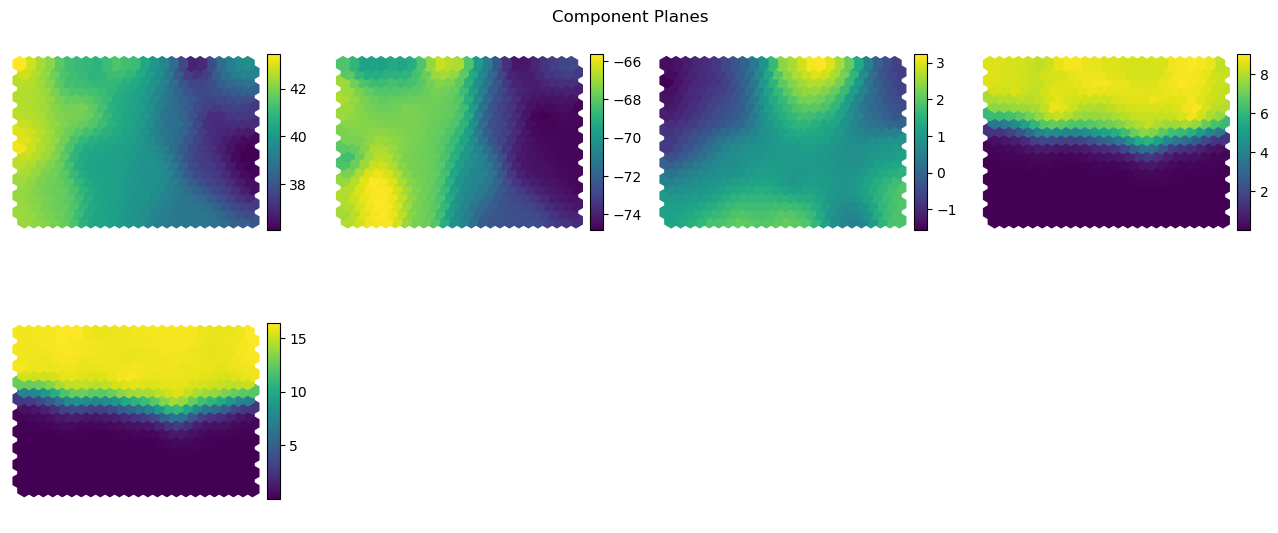

In [7]:
from sompy.visualization.mapview import View2D
view2D  = View2D(msz[0],msz[1],"Component Planes",text_size=10)
view2D.show(sm, col_sz=4, which_dim="all", denormalize=True)

### Hits map
Visualize SOM nodes by density, each node displays how many input vectors are mapped onto each SOM node

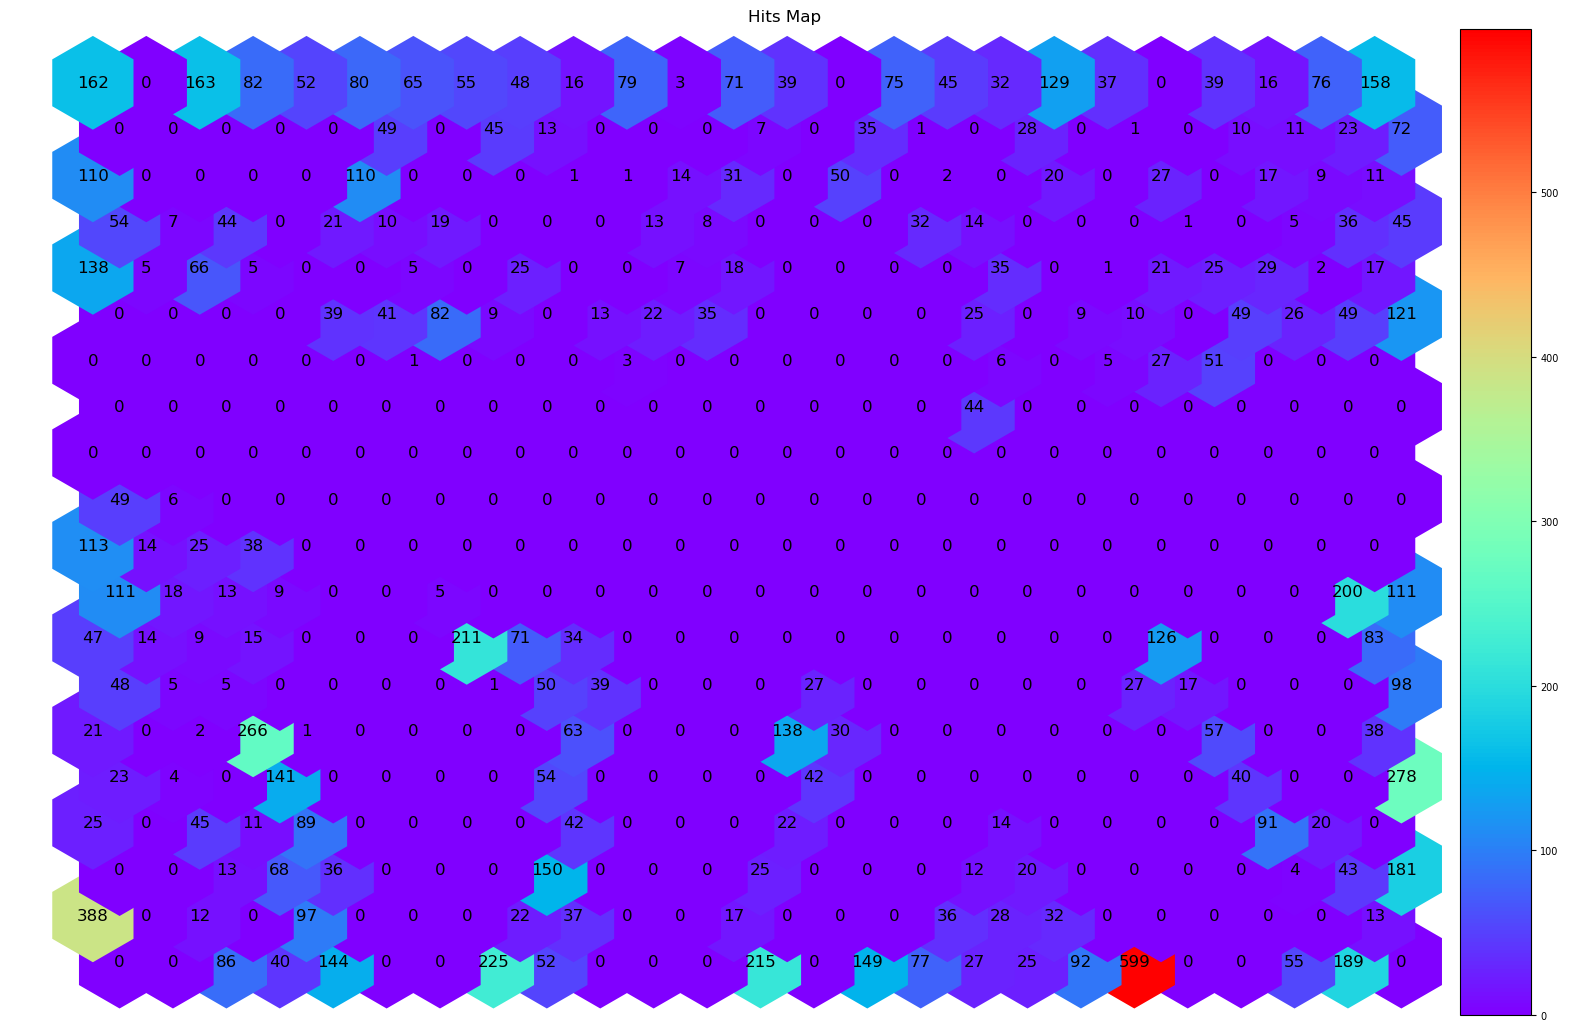

In [8]:
from sompy.visualization.bmuhits import BmuHitsView

vhts  = BmuHitsView(msz[0],msz[1],"Hits Map",text_size=7)
vhts.show(sm, anotate=True, onlyzeros=False, labelsize=12, cmap="rainbow", logaritmic=False)

### U-matrix
The "U-matrix", or "distance matrix" shows the euclidean distances between neighboring units - therefore visualizes the cluster structure of the map. High values on the U-matrix means large distances between neighboring units and thus indicate cluster borders. Clusters typically have uniform areas of low values. 

In [ ]:
from sompy.visualization.hitmap import HitMapView
from sompy.visualization.umatrix import UMatrixView
#k means clustering on data
#hitmap  = HitMapView(msz[0],msz[1],"Cluster Hit Map",text_size=14)
#hitmap.show(sm)

umat  = UMatrixView(msz[0],msz[1],"Unified Distance Matrix", text_size=14)
umat.show(sm)

### Visualize SOM "clusters" on map

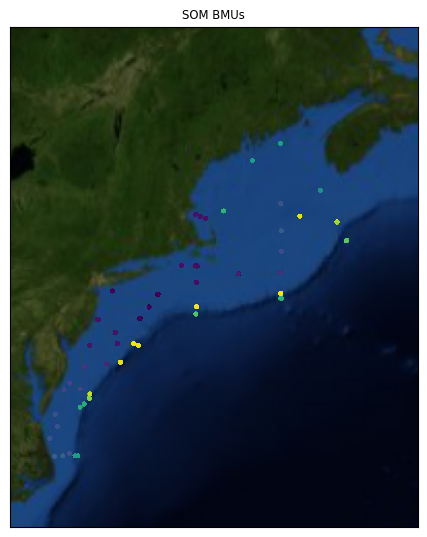

In [9]:
bmu = bmu[0].tolist()
bmus = np.transpose(bmu)
#data for scatter plot
lats = df.lat[:N]
lons = df.lon[:N]

fig = plt.gcf()
fig.set_size_inches(8, 6.5)

m = Basemap(projection='merc', \
            llcrnrlat=34, urcrnrlat=47, \
            llcrnrlon=-77, urcrnrlon=-63, \
            lat_ts=20, \
            resolution='l')
m.bluemarble(scale=1)
#m.shadedrelief(scale=1) # full scale will be overkill
#m.drawcoastlines(color='white', linewidth=0.2)  # add coastlines
x, y = m(lons, lats)  # transform coordinates
plt.scatter(x, y, c=bmus,s=4)
plt.title('SOM BMUs')
plt.show()

Text(0, 0.5, 'Temperature (C)')

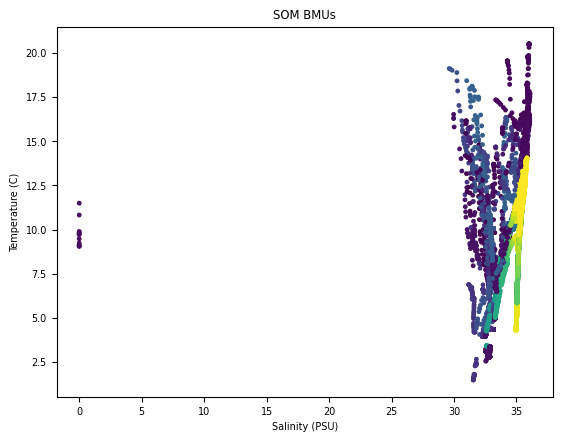

In [10]:
plt.scatter(df.sal[:N], df.temp[:N], c=bmus, s=6)
plt.title('SOM BMUs')
plt.xlabel("Salinity (PSU)")
plt.ylabel("Temperature (C)")

## Hierarchical Agglomerative Clustering

In [ ]:
#K-mean clustering - visualize hit mab with cluster # label
#from sompy.visualization.hitmap import HitMapView
#sm.cluster(4)
#hits  = HitMapView(10,10,"Clustering",text_size=7)
#a=hits.show(sm, labelsize=12)

In [ ]:
#define function to plot dendrogram
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

#another way to create dendrogram


# setting distance_threshold=0 ensures we compute the full tree.
#model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

#model = model.fit(nodes)
#plt.title("Dendrogram")
# plot the top three levels of the dendrogram
#plot_dendrogram(model, truncate_mode="level", p=3)
#plt.xlabel("Number of points in node (or index of point if no parenthesis).")
#plt.show()

### Dendrogram

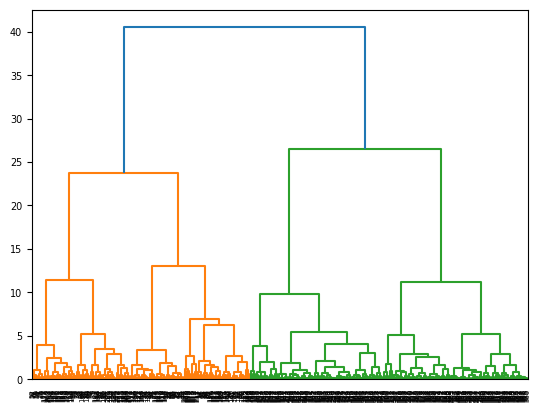

In [12]:
clustering = linkage(nodes, method="ward", metric="euclidean")
dendrogram(clustering)
plt.show()
n_clusters = 7
from scipy.cluster.hierarchy import cut_tree
import seaborn as sns
cluster_labels = cut_tree(clustering, n_clusters=n_clusters).reshape(-1, )
#pred["Cluster"] = cluster_labels

#### Inconsistency coefficient
A link that has a high level of consistency has the same height as the links below it. This is because the distance between the objects being joined is approximately the same as the distances between the objects they contain. A link with consistency indicates there are no distinct divisions between the objects at that level of the hierarchy. 
A link that is inconsistent with the others below it has a noticeably different height than the height of the links below it. This indicates the objects joined at that level in the hierarchy are much further apart when they were joined, which can show natural divisions in the data. 

The inconsistency coefficient for each link is calculated by comparing its height with the average height of other links at the same level of the hierarchy. The larger the coefficient, the greater the difference between the objects connected by the link. 

For links that have no further links below them, the inconsistency coefficient is set to 0.
Table for interpreting output from the inconsistent function (I)

| Column | Description | 
| --- | --- | 
| 1 | Mean of the heights of all the links included in the calculation | 
| 2 | Standard deviation of all the links included in the calculation | 
| 3 | Number of links included in the calculation | 
| 4 | Inconsistency coefficient | 

In [13]:
#inconsistent coefficient

from scipy.cluster.hierarchy import inconsistent, linkage
inc = inconsistent(clustering)
print(inc[:4])

[[0.01497426 0.         1.         0.        ]
 [0.02661872 0.         1.         0.        ]
 [0.02824753 0.         1.         0.        ]
 [0.02909279 0.         1.         0.        ]]


### Cophenetic Correlation 

In [14]:
#cophenetic correlation coefficient
from scipy.cluster.hierarchy import single, cophenet
from scipy.spatial.distance import pdist, squareform

Y = single(pdist(nodes))
Z = clustering
#Z = linkage(Y, "average")

ccc = cophenet(Y)
#squareform(cophenet(Z,Y))

### Visualize SOM topography grouped by HAC clusters

Text(0.5, 1.0, 'SOM nodes grouped by HAC cluster')

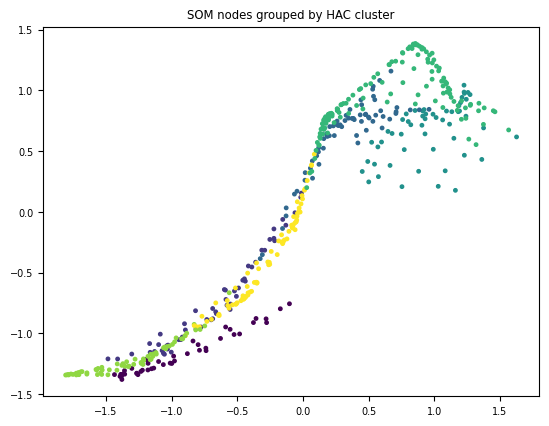

In [15]:
plt.scatter(nodes[:,0], nodes[:,1], c=cluster_labels, s=6)
plt.title('SOM nodes grouped by HAC cluster')

### Visualize a "hit map" of SOM nodes grouped into HAC clusters 

Text(0.5, 1.0, 'Hit map of clusters')

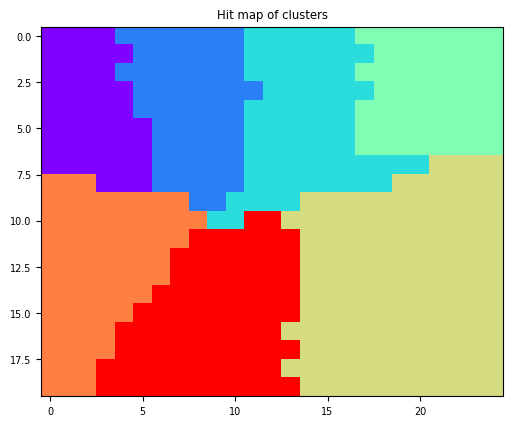

In [16]:
#plt.imshow(clustering.labels_, cmap='hot', interpolation='nearest')
a = cluster_labels.reshape(20,25)
plt.imshow(a, cmap='rainbow')
plt.title('Hit map of clusters')

## Validity Indices

#### Silhouette Score
A general rule of thumb is that a silhouette score above 0.5 indicates a good clustering, a silhouette score below 0.25 indicates a bad clustering, and a silhouette score between 0.25 and 0.5 indicates a fair clustering

In [17]:
avgsilh = sk.metrics.silhouette_score(nodes, cluster_labels)
print('The silhouette score is ' + str(avgsilh))

The silhouette score is 0.39625493697992104


In [18]:
from sklearn.metrics import silhouette_samples
silhouette_values = silhouette_samples(nodes, cluster_labels)

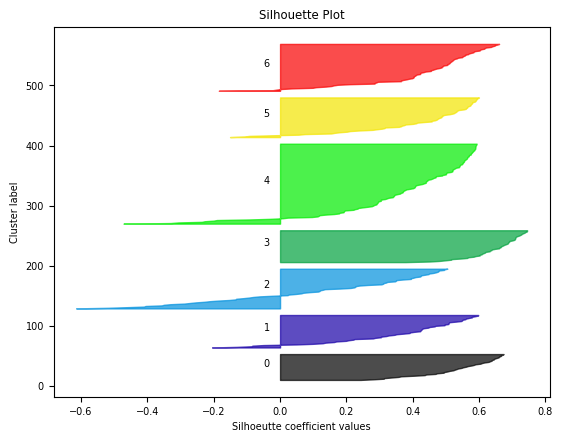

In [19]:
import matplotlib.cm as cm
y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    plt.fill_betweenx(
        np.arange(y_lower, y_upper),
         0,
         ith_cluster_silhouette_values,
         facecolor=color,
         edgecolor=color,
         alpha=0.7,
        )
        # Label the silhouette plots with their cluster numbers at the middle
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples
    plt.title('Silhouette Plot')
    plt.xlabel('Silhoeutte coefficient values')
    plt.ylabel('Cluster label')

#### Calinski Harabasz Score
Calinski-Harabasz Score is used to evaluate a model when using unsupervised clustering (when no "true" labels are known) 

Class: internal cluster validation 

CHI (also called variance ratio criterion) "is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). Here cohesion is estimated based on the distances from the data points in a cluster to its cluster centroid and separation is based on the distance of the cluster centroids from the global centroid" (gfg).
"Higher value of CH index means the clusters are dense and well separated, although there is no “acceptable” cut-off value. We need to choose that solution which gives a peak or at least an abrupt elbow on the line plot of CH indices. On the other hand, if the line is smooth (horizontal or ascending or descending) then there is no such reason to prefer one solution over others" (gfg).

In [20]:
from sklearn import metrics
from sklearn.metrics import pairwise_distances
chi = metrics.calinski_harabasz_score(nodes, cluster_labels)
print('The Calinski Harabasz Index is ' + str(chi))

The Calinski Harabasz Index is 487.80660339613945


#### Davies Bouldin Score
Davies-Bouldin Index is used to evaluate a model when using unsupervised clustering (when no "true" labels are known) 
The lower the index, the better the separation between the clusters 

This index signifies the average ‘similarity’ between clusters, where the similarity is a measure that compares the distance between clusters with the size of the clusters themselves.

Zero is the lowest possible sco. Values closer to 0 represent a better score

(Definition from https://scikit-learn.org/stable/modules/clustering.html#visualization-of-cluster-hierarchy) 
ns.

In [21]:
from sklearn.metrics import davies_bouldin_score
db = davies_bouldin_score(nodes, cluster_labels)
print('The Davies Bouldin score is ' + str(db))

The Davies Bouldin score is 0.8232884087079443


In [ ]:
#bmu = bmu[0].tolist()
bmus = np.transpose(bmu)
#all_data = np.append(data, bmus, 1)
#all_data.shape

In [ ]:
#format bmu as needed (as np array)
#bmus = sm._bmu
#bmu = bmus[0].tolist()
#bmus = np.transpose(bmu)

## Visualization of final clusters

## <font color='red'> CHECK IF THE CLUS LABELS ARE ORDERED CORRECTLY
Did the order of the t-s change when grouping... did labels follow correctly?

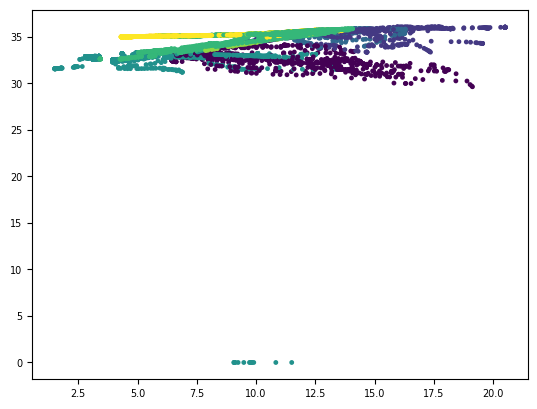

In [22]:
#loop thru and find data with the same BMUs 
clus_nds = []
for x in range(500):
    itr = np.where(bmus==x)
    clus_nds.append(itr) #clus_nds are INDEX/ locations.. does not contain actual data 

ts = ['lat','lon','temp','sal','date','depth']
data_ts = df[ts].values
data_ts = data_ts[:N]

#cluster data into 500 arrays (each for one node)
dat_ts = []
for x in range(500):
    d = data_ts[clus_nds[x]]
    dat_ts.append(d)


#repeat cluster numbers for number of observations in each node
#NOT SURE THIS IS IN ORDER THO 
cn = []
for x in range(500):
    clusnum = np.tile(cluster_labels[x], (len(dat_ts[x]), 1))
    cn.append(clusnum)

#check if this is in order
cnn = np.concatenate(cn)
all = np.concatenate(dat_ts)

lon = all[:,1]
lat = all[:,0]
temp = all[:,2]
sal = all[:,3]
dat = all[:,4]
depth = all[:,5]

plt.scatter(temp,sal,c=cnn,s=6)

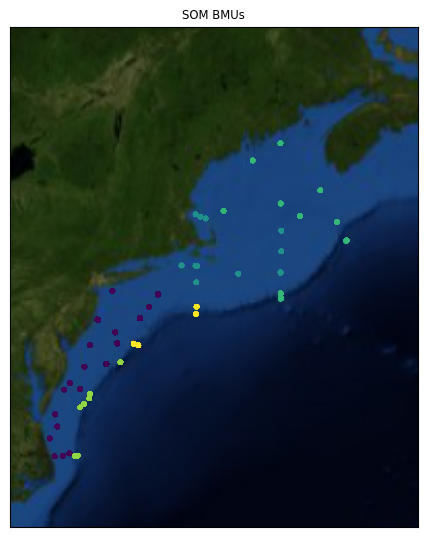

In [23]:
lats = lat
lons = lon

fig = plt.gcf()
fig.set_size_inches(8, 6.5)

m = Basemap(projection='merc', \
            llcrnrlat=34, urcrnrlat=47, \
            llcrnrlon=-77, urcrnrlon=-63, \
            lat_ts=20, \
            resolution='l')
m.bluemarble(scale=1)
#m.shadedrelief(scale=1) # full scale will be overkill
#m.drawcoastlines(color='white', linewidth=0.2)  # add coastlines
x, y = m(lons, lats)  # transform coordinates
plt.scatter(x, y, c=cnn,s=8)
plt.title('SOM BMUs')
plt.show()

In [24]:
#da = np.insert(all,2,cnn, axis=1)
da = np.hstack((all,cnn))
print(da)
np.savetxt('clusnum1.txt', da, delimiter=',')

[[ 4.0355000e+01 -7.1918300e+01  1.3020000e+01 ...  2.0100527e+07
   1.3000000e+01  0.0000000e+00]
 [ 4.0355000e+01 -7.1918300e+01  1.2840000e+01 ...  2.0100527e+07
   1.4000000e+01  0.0000000e+00]
 [ 4.0355000e+01 -7.1918300e+01  1.2250000e+01 ...  2.0100527e+07
   1.5000000e+01  0.0000000e+00]
 ...
 [ 4.2220000e+01 -6.5768300e+01  9.8800000e+00 ...  2.0150528e+07
   1.9300000e+02  4.0000000e+00]
 [ 4.2220000e+01 -6.5768300e+01  9.8000000e+00 ...  2.0150528e+07
   1.9400000e+02  4.0000000e+00]
 [ 4.2220000e+01 -6.5768300e+01  9.7200000e+00 ...  2.0150528e+07
   1.9500000e+02  4.0000000e+00]]



# <font color='red'> END HERE
<font color='red'>
EXTRA WAYS TO PLOT THE SAME THING

In [ ]:

#loop thru and find data with the same BMUs 
clus_nds = []
for x in range(499):
    itr = np.where(bmus==x)
    clus_nds.append(itr) #clus_nds are INDEX/ locations.. does not contain actual data 

In [ ]:
#cluster data into 500 arrays (each for one node)
#dat = []
#for x in range(499):
#    d = all_data[clus_nds[x]]
#    dat.append(d)

#repeat cluster numbers for number of observations in each node
#cn = []
#for x in range(499):
#    clusnum = np.tile(cluster_labels[x], (len(dat[x]), 1))
#    cn.append(clusnum)

#NEED TO PLOT PROPERLY
#for x in range(499):
#    g = len(dat[x])
#    for k in range(g):
#        plt.scatter(dat[x][k][0], dat[x][k][1], c=cn[x][k], s=6)

In [ ]:
ts = ['temp','sal']
data_ts = df[ts].values
data_ts = data_ts[:N]

#cluster data into 500 arrays (each for one node)
dat_ts = []
for x in range(499):
    d = data_ts[clus_nds[x]]
    dat_ts.append(d)

In [ ]:
#repeat cluster numbers for number of observations in each node
cn = []
for x in range(499):
    clusnum = np.tile(cluster_labels[x], (len(dat_ts[x]), 1))
    cn.append(clusnum)

In [ ]:
#ideally I would vertically concatenate a np array with t,s,clus num so that I wouldn't have to plot in a loop........ figure that out
#loop in hstack to get wanted vars together, but how to vert stack in a loop?????
for x in range(499):
    g = len(dat_ts[x])
    for k in range(g):
        if cn[x][k] == 0:
            plt.scatter(dat_ts[x][k][1], dat_ts[x][k][0], c='lightpink', s=6)
        elif cn[x][k] == 1:
            plt.scatter(dat_ts[x][k][1], dat_ts[x][k][0], c='orchid', s=6)
        elif cn[x][k] == 2:
            plt.scatter(dat_ts[x][k][1], dat_ts[x][k][0], c='thistle', s=6)
        elif cn[x][k] == 3:
            plt.scatter(dat_ts[x][k][1], dat_ts[x][k][0], c='mediumpurple', s=6)
        elif cn[x][k] == 4:
            plt.scatter(dat_ts[x][k][1], dat_ts[x][k][0], c='lightskyblue', s=6)
        elif cn[x][k] == 5:
            plt.scatter(dat_ts[x][k][1], dat_ts[x][k][0], c='paleturquoise', s=6)
        elif cn[x][k] == 6:
            plt.scatter(dat_ts[x][k][1], dat_ts[x][k][0], c='turquoise', s=6)
        elif cn[x][k] == 7:
            plt.scatter(dat_ts[x][k][1], dat_ts[x][k][0], c='palegreen', s=6)
        elif cn[x][k] == 8:
            plt.scatter(dat_ts[x][k][1], dat_ts[x][k][0], c='darkseagreen', s=6)
        elif cn[x][k] == 9:
            plt.scatter(dat_ts[x][k][1], dat_ts[x][k][0], c='beige', s=6)
        elif cn[x][k] == 10:
            plt.scatter(dat_ts[x][k][1], dat_ts[x][k][0], c='moccasin', s=6)
        elif cn[x][k] == 11:
            plt.scatter(dat_ts[x][k][1], dat_ts[x][k][0], c='salmon', s=6)
plt.title('Final Clusters')
plt.xlabel("Salinity (PSU)")
plt.ylabel("Temperature (C)")
#plt.legend(['1','2','3'])


In [ ]:
ts = ['lat','lon']
data_ts = df[ts].values
data_ts = data_ts[:N]

#cluster data into 500 arrays (each for one node)
dat_ts = []
for x in range(499):
    d = data_ts[clus_nds[x]]
    dat_ts.append(d)

In [ ]:
for x in range(499):
    g = len(dat_ts[x])
    for k in range(g):
        if cn[x][k] == 0:
            plt.scatter(dat_ts[x][k][0], dat_ts[x][k][1], c='lightpink', s=6)
        elif cn[x][k] == 1:
            plt.scatter(dat_ts[x][k][0], dat_ts[x][k][1], c='orchid', s=6)
        elif cn[x][k] == 2:
            plt.scatter(dat_ts[x][k][0], dat_ts[x][k][1], c='thistle', s=6)
        elif cn[x][k] == 3:
            plt.scatter(dat_ts[x][k][0], dat_ts[x][k][1], c='mediumpurple', s=6)
        elif cn[x][k] == 4:
            plt.scatter(dat_ts[x][k][0], dat_ts[x][k][1], c='lightskyblue', s=6)
        elif cn[x][k] == 5:
            plt.scatter(dat_ts[x][k][0], dat_ts[x][k][1], c='paleturquoise', s=6)
        elif cn[x][k] == 6:
            plt.scatter(dat_ts[x][k][0], dat_ts[x][k][1], c='turquoise', s=6)
        elif cn[x][k] == 7:
            plt.scatter(dat_ts[x][k][0], dat_ts[x][k][1], c='palegreen', s=6)
        elif cn[x][k] == 8:
            plt.scatter(dat_ts[x][k][0], dat_ts[x][k][1], c='darkseagreen', s=6)
        elif cn[x][k] == 9:
            plt.scatter(dat_ts[x][k][0], dat_ts[x][k][1], c='beige', s=6)
        elif cn[x][k] == 10:
            plt.scatter(dat_ts[x][k][0], dat_ts[x][k][1], c='moccasin', s=6)
        elif cn[x][k] == 11:
            plt.scatter(dat_ts[x][k][0], dat_ts[x][k][1], c='salmon', s=6)
plt.title('Final Clusters')
plt.xlabel("Latitude")
plt.ylabel("Longitude")

In [ ]:
print(data)

In [ ]:
data =  np.insert(data, 5, cnn, axis=1)

In [ ]:
print(data)

In [ ]:
# importing the csv module
import csv
 
# my data rows as dictionary objects
mydict = cnn.tolist()
#fieldnames
fields = ['clusnum']
#filename 
filename = 'clusnum.csv'

with open(filename, 'w') as csvfile:
    # creating a csv dict writer object
    writer = csv.DictWriter(csvfile, fieldnames=fields)
 
    # writing headers (field names)
    writer.writeheader()
 
    # writing data rows
    writer.writerows(mydict)

In [ ]:
# importing the csv module
import csv
 
# my data rows as dictionary objects
mydict = [{'branch': 'COE', 'cgpa': '9.0', 'name': 'Nikhil', 'year': '2'},
          {'branch': 'COE', 'cgpa': '9.1', 'name': 'Sanchit', 'year': '2'},
          {'branch': 'IT', 'cgpa': '9.3', 'name': 'Aditya', 'year': '2'},
          {'branch': 'SE', 'cgpa': '9.5', 'name': 'Sagar', 'year': '1'},
          {'branch': 'MCE', 'cgpa': '7.8', 'name': 'Prateek', 'year': '3'},
          {'branch': 'EP', 'cgpa': '9.1', 'name': 'Sahil', 'year': '2'}]
 
# field names
fields = ['name', 'branch', 'year', 'cgpa']
 
# name of csv file
filename = "university_records.csv"
 
# writing to csv file
with open(filename, 'w') as csvfile:
    # creating a csv dict writer object
    writer = csv.DictWriter(csvfile, fieldnames=fields)
 
    # writing headers (field names)
    writer.writeheader()
 
    # writing data rows
    writer.writerows(mydict)

In [ ]:
type(mydict)

In [ ]:
np.savetxt('test.out', cnn, delimiter=',')

In [ ]:
print(cnn)

In [ ]:
len(cnn)

In [ ]:
len(cluster_labels)

In [ ]:
print(all)

In [ ]:
type(data)